In [1]:
import sys
sys.path.insert(0,"../")

In [2]:
import numpy as np
import pandas as pd
import os 
import torch
import random


In [3]:
import pickle

In [4]:
import collections, os, io
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset
import random
import pickle
import core.utils_disco as utils_disco
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import ipdb 
st = ipdb.set_trace

In [5]:
print(os.listdir('/home/mprabhud/dataset/clevr_veggies/npys'))

dataset_path = '/home/mprabhud/dataset/clevr_veggies/npys'

['sp', 'shapenet_temp', 'be_lv.txt', 'bb_lt.txt', 'bd_lt.txt', 'bc_lv.txt', 'shapenet_13v.txt', 'bd_l', 'cylinder_13v.txt', 'ba_lv.txt', 'shapenet_tempt.txt', 'bb_lv.txt', 'be_lt.txt', 'cylinder_13', 'ba_l', '.ipynb_checkpoints', 'ba_lt.txt', 'shapenet_tempv.txt', 'cylinder_13t.txt', 'shapenet_13t.txt', 'bc_l', 'bc_lt.txt', 'bd_lv.txt', 'bb_l', 'shapenet_13']


In [6]:
data = pickle.load(open('/home/mprabhud/dataset/clevr_veggies/npys/bc_l/CLEVR_new_000088.p', "rb"))

In [7]:
data.keys()

dict_keys(['tree_seq_filename', 'pix_T_cams_raw', 'origin_T_camXs_raw', 'rgb_camXs_raw', 'camR_T_origin_raw', 'xyz_camXs_raw'])

In [8]:
data['rgb_camXs_raw'].shape, data['origin_T_camXs_raw'].shape

((40, 256, 256, 4), (40, 4, 4))

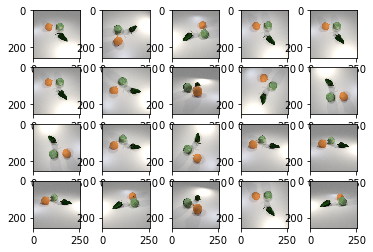

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(4,5)
for row in range(4):
    for col in range(5):
        axarr[row,col].imshow(data['rgb_camXs_raw'][4*row + col,:,:,:3])

In [10]:
data['tree_seq_filename']

'CLEVR_MULTIPLE_256_NO_SHEAR_LOW_ELEVATION_3/trees_updated/train/CLEVR_new_000088.tree'

In [11]:
hyp_N = 10

In [12]:
def bbox_rearrange(tree,boxes= [],classes={},all_classes=[]):
	for i in range(0, tree.num_children):
		updated_tree,boxes,classes,all_classes = bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
		tree.children[i] = updated_tree     
	if tree.function == "describe":
		xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
		box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
		tree.bbox_origin = box
		boxes.append(box)
		classes["shape"] = tree.word
		all_classes.append(classes)
		classes = {}
	if tree.function == "combine":
		if "large" in tree.word or "small" in tree.word:
			classes["size"] = tree.word
		elif "metal" in tree.word or "rubber" in tree.word:
			classes["material"] = tree.word
		else:
			classes["color"] = tree.word
	return tree,boxes,classes,all_classes

In [13]:
tree = pickle.load(open(os.path.join("/home/mprabhud/dataset/clevr_veggies",data['tree_seq_filename']),"rb"))
tree,boxes,_,_ = bbox_rearrange(tree,boxes=[],classes={},all_classes=[])

In [14]:
boxes = np.stack(boxes)

In [15]:
def collate_boxes(data):
    query_image, num_boxes_q, boxes_q, key_image, num_boxes_k, boxes_k, scene_num, query_img_view, key_img_view, pix_T_cams_raw, camR_T_origin_raw, origin_T_camXs_raw, gt_egomotion, idx = zip(*data)
    batch_size = len(num_boxes_q)
    
#     print(torch.stack(list(query_image)))
    query_image = torch.stack(list(query_image))
    key_image = torch.stack(list(key_image))
    
 
    num_boxes_q = torch.as_tensor(list(num_boxes_q))
    num_boxes_k = torch.as_tensor(list(num_boxes_k))
    
    boxes_q = list(boxes_q)
    boxes_k = list(boxes_k)
 
    object_boxes_q = torch.cat(boxes_q, dim=0)
    object_boxes_k = torch.cat(boxes_k, dim=0)
    
    scene_num = torch.as_tensor(list(scene_num))
    query_img_view = torch.as_tensor(list(query_img_view))
    index = torch.as_tensor(list(idx))
    key_img_view = torch.as_tensor(list(key_img_view))
    pix_T_cams_raw = torch.stack(list(pix_T_cams_raw), dim=0)
    camR_T_origin_raw = torch.stack(list(camR_T_origin_raw), dim=0)
    origin_T_camXs_raw = torch.stack(list(origin_T_camXs_raw), dim=0)
    gt_egomotion = torch.stack(list(gt_egomotion), dim=0)
    
    
    metadata = {"index": index, "scene_number":scene_num, "query_image_index":query_img_view,"key_image_index":key_img_view, "pix_T_cams_raw":torch.as_tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.as_tensor(camR_T_origin_raw).cuda(), "origin_T_camXs_raw":torch.as_tensor(origin_T_camXs_raw).cuda(), "rel_viewpoint":torch.as_tensor(gt_egomotion).cuda()}
    feed_dict_q = {"images":torch.as_tensor(query_image).cuda(), "objects":num_boxes_q, "objects_boxes":torch.as_tensor(object_boxes_q).cuda()}
    feed_dict_k = {"images":torch.as_tensor(key_image).cuda(), "objects":num_boxes_k, "objects_boxes":torch.as_tensor(object_boxes_k).cuda()}
    
    
    return feed_dict_q, feed_dict_k, metadata

In [16]:
class CLEVR_train(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, few_shot=False):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_res = 256
        self.N = 10
        self.few_shot = few_shot
        self.views = 18

        if root_dir.endswith("txt"):
            data  = []

            with open(root_dir) as f:
                lines = f.readlines()

                for line in lines:
                    data.append(line.split()[0])

            self.all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]
        else:
            self.all_files = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.endswith('.p')]
            
        self.all_files.sort()
            
        print('Initialised.....',len(self.all_files),' files...')
            
    def bbox_rearrange(self,tree,boxes= [],classes={},all_classes=[]):
        for i in range(0, tree.num_children):
            updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
            tree.children[i] = updated_tree     
        if tree.function == "describe":
            xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
            box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
            tree.bbox_origin = box
            boxes.append(box)
            classes["shape"] = tree.word
            all_classes.append(classes)
            classes = {}
        if tree.function == "combine":
            if "large" in tree.word or "small" in tree.word:
                classes["size"] = tree.word
            elif "metal" in tree.word or "rubber" in tree.word:
                classes["material"] = tree.word
            else:
                classes["color"] = tree.word
        return tree,boxes,classes,all_classes

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx, is_pickle=True):
        
        #print(idx)

        scene_num = idx 
        
        
        query_img_view, key_img_view = random.sample(range(0, self.views), 2)
        index = scene_num*self.views + query_img_view
        

        scene_path = self.all_files[scene_num]
        data = pickle.load(open(scene_path, "rb"))
        
        #gt egomotion
        '''
        matmul(query_camX_T_origin, target_camX_T_origin.inverse())
        '''
        
        query_camX_T_origin = torch.as_tensor(data['origin_T_camXs_raw'][query_img_view]).reshape(1,4,4)
        origin_T_camX_target = utils_disco.safe_inverse(torch.as_tensor(data['origin_T_camXs_raw'][key_img_view]).reshape(1, 4, 4))
        viewpoints = torch.matmul(query_camX_T_origin, origin_T_camX_target)
        
        rx, ry, rz = utils_disco.rotm2eul(viewpoints)
        rx, ry, rz = rx.unsqueeze(1), ry.unsqueeze(1), rz.unsqueeze(1)
        xyz = viewpoints[:, :3, -1]


        view_vector = [xyz, torch.cos(rx), torch.sin(rx), torch.cos(rz), torch.sin(rz)]
        rel_viewpoint = torch.cat(view_vector, dim=-1)
        
        images = torch.as_tensor(data['rgb_camXs_raw']).permute(0,3,1,2)/255.
        _, _, H_orig, W_orig = images.shape
        query_image, key_image = images[query_img_view,:3,:,:], images[key_img_view,:3,:,:]
        
        tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
        tree_path = tree_path.replace("datasets","dataset")
        
        tree_file = pickle.load(open(os.path.join(tree_path),"rb"))
        tree,boxes,_,_ = self.bbox_rearrange(tree_file,boxes=[],classes={},all_classes=[])
        boxes = np.stack(boxes)
        num_boxes, _ = boxes.shape
        boxes = boxes.reshape(1,1,num_boxes,2,3)
        boxes = torch.as_tensor(boxes).cuda()
        
        camXs_T_origin_q =  utils_disco.safe_inverse(torch.as_tensor(data['origin_T_camXs_raw'][query_img_view]).reshape(1, 4, 4)).unsqueeze(1).cuda()
        pix_T_camXs_q = torch.as_tensor(data['pix_T_cams_raw'][query_img_view]).reshape(1,1,4,4).cuda()
        query_image = query_image.reshape(1,1,3,H_orig,W_orig)
        boxes_q = utils_disco.get_bounding_boxes(torch.as_tensor(query_image), boxes, camXs_T_origin_q, pix_T_camXs_q, num_boxes)
        
        camXs_T_origin_k =  utils_disco.safe_inverse(torch.as_tensor(data['origin_T_camXs_raw'][key_img_view]).reshape(1, 4, 4)).unsqueeze(1).cuda()
        pix_T_camXs_k = torch.as_tensor(data['pix_T_cams_raw'][key_img_view]).reshape(1,1,4,4).cuda()
        key_image = key_image.reshape(1,1,3,H_orig,W_orig)
        boxes_k = utils_disco.get_bounding_boxes(torch.as_tensor(key_image), boxes, camXs_T_origin_k, pix_T_camXs_k, num_boxes)

        #images = images.permute(0,2,3,1)
        query_image, key_image = images[query_img_view,:3,:,:], images[key_img_view,:3,:,:]
        
        pix_T_cams_raw = np.stack((data['pix_T_cams_raw'][query_img_view], data['pix_T_cams_raw'][key_img_view]))
        # print("Pixt camXs shape: ", pix_T_cams_raw.shape)
        if not self.few_shot:
            pix_T_cams_raw = utils_disco.scale_intrinsics(torch.as_tensor(pix_T_cams_raw), self.target_res/(1.*W_orig), self.target_res/(1.*H_orig))
        
        
        camR_T_origin_raw = np.stack((data['camR_T_origin_raw'][query_img_view], data['camR_T_origin_raw'][key_img_view]))
        origin_T_camXs_raw = np.stack((data['origin_T_camXs_raw'][query_img_view], data['origin_T_camXs_raw'][key_img_view]))
        
        return torch.as_tensor(query_image), num_boxes, torch.as_tensor(boxes_q), torch.as_tensor(key_image), num_boxes, torch.as_tensor(boxes_k), scene_num, query_img_view, key_img_view, torch.as_tensor(pix_T_cams_raw), torch.as_tensor(camR_T_origin_raw), torch.as_tensor(origin_T_camXs_raw), torch.as_tensor(rel_viewpoint), index


In [17]:
train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5t.txt')

Initialised..... 251  files...


In [18]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_boxes)

In [19]:
for b in train_loader:
    feed_dict_q, feed_dict_k, metadata = b
    break
    

../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [20]:
metadata['scene_number'], metadata['key_image_index'], metadata['query_image_index'], metadata['index']

(tensor([166, 158,  45,  93, 141]),
 tensor([13,  8,  8, 14,  4]),
 tensor([ 6,  1,  7, 15, 14]),
 tensor([2994, 2845,  817, 1689, 2552]))

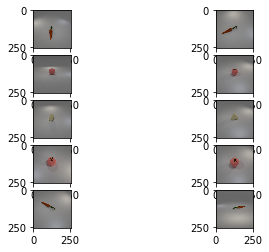

In [21]:
f, axarr = plt.subplots(5,2)
for row in range(5):
    axarr[row,0].imshow(feed_dict_q['images'][row].detach().cpu().permute(1,2,0))
    axarr[row,1].imshow(feed_dict_k['images'][row].detach().cpu().permute(1,2,0))

In [22]:
feed_dict_q['images'].shape, feed_dict_q['objects'].shape, feed_dict_q['objects_boxes'].shape

(torch.Size([5, 3, 256, 256]), torch.Size([5]), torch.Size([5, 4]))

In [23]:

feed_dict_q['objects']

tensor([1, 1, 1, 1, 1])

In [24]:
feed_dict_q['objects_boxes'].shape

torch.Size([5, 4])

In [25]:
metadata['pix_T_cams_raw'].shape

torch.Size([5, 2, 4, 4])

In [26]:
metadata['camR_T_origin_raw'].shape

torch.Size([5, 2, 4, 4])

In [27]:
metadata['origin_T_camXs_raw'].shape

torch.Size([5, 2, 4, 4])

In [28]:
metadata['rel_viewpoint'].shape

torch.Size([5, 1, 7])

In [33]:
def collate_boxes_onlyquery(data):
    query_image, num_boxes_q, boxes_q, scene_num, pix_T_cams_raw, camR_T_origin_raw, query_img_view, idx = zip(*data)
    batch_size = len(num_boxes_q)
    
#     print(torch.stack(list(query_image)))
    query_image = torch.stack(list(query_image))
    
    num_boxes_q = torch.as_tensor(list(num_boxes_q))
    
    boxes_q = list(boxes_q)
 
    object_boxes_q = torch.cat(boxes_q, dim=0)
    
    scene_num = torch.as_tensor(list(scene_num))
    query_img_view = torch.as_tensor(list(query_img_view))
    idx = torch.as_tensor(list(idx))
    
    pix_T_cams_raw = torch.stack(list(pix_T_cams_raw), dim=0)
    camR_T_origin_raw = torch.stack(list(camR_T_origin_raw), dim=0)
    
    
    metadata = {"index":idx, "query_image_index":query_img_view ,"scene_number":scene_num, "pix_T_cams_raw":torch.as_tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.as_tensor(camR_T_origin_raw).cuda()}
    feed_dict_q = {"images":torch.as_tensor(query_image).cuda(), "objects":num_boxes_q, "objects_boxes":torch.as_tensor(object_boxes_q).cuda()}
    
    return feed_dict_q, metadata


class CLEVR_train_onlyquery(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, few_shot=False):
        self.root_dir = root_dir
        self.views = 18

        if root_dir.endswith("txt"):
            data  = []

            with open(root_dir) as f:
                lines = f.readlines()

                for line in lines:
                    data.append(line.split()[0])

            self.all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]
        else:
            self.all_files = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.endswith('.p')]
            
        self.all_files.sort()
            
        print('Initialised.....',len(self.all_files)*self.views,' files...')
            
    def bbox_rearrange(self,tree,boxes= [],classes={},all_classes=[]):
        for i in range(0, tree.num_children):
            updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
            tree.children[i] = updated_tree     
        if tree.function == "describe":
            xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
            box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
            tree.bbox_origin = box
            boxes.append(box)
            classes["shape"] = tree.word
            all_classes.append(classes)
            classes = {}
        if tree.function == "combine":
            if "large" in tree.word or "small" in tree.word:
                classes["size"] = tree.word
            elif "metal" in tree.word or "rubber" in tree.word:
                classes["material"] = tree.word
            else:
                classes["color"] = tree.word
        return tree,boxes,classes,all_classes

    def __len__(self):
        return len(self.all_files)*self.views

    def __getitem__(self, idx, is_pickle=True):
        
        #print(idx)

        scene_num = idx // self.views
        query_img_view = idx % self.views

        scene_path = self.all_files[scene_num]
        
        data = pickle.load(open(scene_path, "rb"))
        
        #gt egomotion

        
        images = torch.as_tensor(data['rgb_camXs_raw']).permute(0,3,1,2)/255.
        _, _, H_orig, W_orig = images.shape
        query_image = images[query_img_view,:3,:,:]
        
        tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
        tree_path = tree_path.replace("datasets","dataset")
        
        tree_file = pickle.load(open(os.path.join(tree_path),"rb"))
        tree,boxes,_,_ = self.bbox_rearrange(tree_file,boxes=[],classes={},all_classes=[])
        boxes = np.stack(boxes)
        num_boxes, _ = boxes.shape
        boxes = boxes.reshape(1,1,num_boxes,2,3)
        boxes = torch.as_tensor(boxes).cuda()
        
        camXs_T_origin_q =  utils_disco.safe_inverse(torch.as_tensor(data['origin_T_camXs_raw'][query_img_view]).reshape(1, 4, 4)).unsqueeze(1).cuda()
        pix_T_camXs_q = torch.as_tensor(data['pix_T_cams_raw'][query_img_view]).reshape(1,1,4,4).cuda()
        query_image = query_image.reshape(1,1,3,H_orig,W_orig)
        boxes_q = utils_disco.get_bounding_boxes(torch.as_tensor(query_image), boxes, camXs_T_origin_q, pix_T_camXs_q, num_boxes)
        
        
        #images = images.permute(0,2,3,1)
        query_image = images[query_img_view,:3,:,:]
        
        pix_T_cams_raw = (data['pix_T_cams_raw'][query_img_view])
        # print("Pixt camXs shape: ", pix_T_cams_raw.shape)
        
        
        camR_T_origin_raw = data['camR_T_origin_raw'][query_img_view]
        origin_T_camXs_raw = data['origin_T_camXs_raw'][query_img_view]
        
        return torch.as_tensor(query_image), num_boxes, torch.as_tensor(boxes_q), scene_num, torch.as_tensor(pix_T_cams_raw), torch.as_tensor(camR_T_origin_raw), query_img_view, idx


In [34]:
train_dataset_kmeans = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5t.txt')

Initialised..... 4518  files...


In [35]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_kmeans, batch_size=5, shuffle=True, collate_fn=collate_boxes_onlyquery)

In [36]:
for b in train_loader:
    feed_dict_q, metadata = b
    break

In [37]:
metadata['scene_number'], metadata['query_image_index'], metadata['index']

(tensor([ 90,   0, 227, 208,  56]),
 tensor([ 9, 15, 17, 10,  5]),
 tensor([1629,   15, 4103, 3754, 1013]))

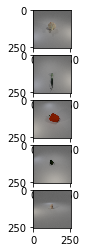

In [38]:
f, axarr = plt.subplots(5)
for row in range(5):
    axarr[row].imshow(feed_dict_q['images'][row].detach().cpu().permute(1,2,0))

In [39]:
feed_dict_q['images'].shape, feed_dict_q['objects'].shape, feed_dict_q['objects_boxes'].shape

(torch.Size([5, 3, 256, 256]), torch.Size([5]), torch.Size([5, 4]))

In [40]:
metadata['pix_T_cams_raw'].shape

torch.Size([5, 4, 4])